---
title: Gradient Considerations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

In [1]:
import sys, os

# spyder up to find the root
oceanbench_root = "/gpfswork/rech/cli/uvo53rl/projects/oceanbench"

# append to path
sys.path.append(str(oceanbench_root))

In [2]:
import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
import metpy
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF


sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Processing Chain

**Part I**:

* Open Dataset
* Validate Coordinates + Variables
* Decode Time
* Select Region
* Sortby Time

**Part II**: Regrid

**Part III**:

* Interpolate Nans
* Add Units
* Spatial Rescale
* Time Rescale

**Part IV**: Metrics

*

## Data

In [3]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [4]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/DUACS

2020a_SSH_mapping_NATL60_DUACS_en_j1_tpn_g2.nc	     ssh_DUACS_swot_4nadir.nc
2020a_SSH_mapping_NATL60_DUACS_swot_en_j1_tpn_g2.nc  ssh_DUACS_swot.nc
ssh_DUACS_4nadir.nc


In [5]:
# !cat configs/postprocess.yaml

In [6]:
# # load config
# config_dm = OmegaConf.load('./configs/postprocess.yaml')

# # instantiate
# ds = hydra.utils.instantiate(config_dm.NATL60_GF_1Y1D)
# ds

In [7]:
from oceanbench._src.geoprocessing.gridding import grid_to_regular_grid, coord_based_to_grid
from oceanbench._src.geoprocessing import geostrophic as geocalc
from metpy.units import units

In [8]:
def calculate_physical_quantities(da):
    da["ssh"] = da.ssh * units.meters
    da = geocalc.streamfunction(da, "ssh")
    da = geocalc.geostrophic_velocities(da, variable="psi")
    da = geocalc.kinetic_energy(da, variables=["u", "v"])
    da = geocalc.divergence(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "div")
    da = geocalc.relative_vorticity(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "vort_r")
    da = geocalc.strain_magnitude(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, variable="strain")
    return da

In [9]:
def correct_labels(ds):
    
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["ssh"].attrs["units"] = "m"
    ds["ssh"].attrs["standard_name"] = "sea_surface_height"
    ds["ssh"].attrs["long_name"] = "Sea Surface Height"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"
    
    return ds
    

## Reference Dataset

For the reference dataset, we will look at the NEMO simulation of the Gulfstream.

In [10]:
%%time

# load config
config_dm = OmegaConf.load('./configs/postprocess.yaml')

# instantiate
ds_natl60 = hydra.utils.instantiate(config_dm.NATL60_GF_FULL).compute()
ds_natl60

CPU times: user 12 s, sys: 2.53 s, total: 14.5 s
Wall time: 43.5 s


<xarray.Dataset>
Dimensions:  (time: 42, lat: 600, lon: 600)
Coordinates:
  * lon      (lon) float64 -64.98 -64.97 -64.95 -64.93 ... -55.03 -55.02 -55.0
  * lat      (lat) float64 33.02 33.03 33.05 33.07 ... 42.95 42.97 42.98 43.0
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh      (time, lat, lon) float32 0.6549 0.6571 0.6593 ... -0.2152 -0.2174
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

In [11]:
nadir4_config = OmegaConf.load(f'./configs/natl60_obs.yaml')
ds_nadir4 = hydra.utils.instantiate(nadir4_config.ALONGTRACK_NADIR4.data).compute()
ds_swot1nadir5 = hydra.utils.instantiate(nadir4_config.ALONGTRACK_SWOT1NADIR5.data).compute()
ds_swot1nadir5

<xarray.Dataset>
Dimensions:  (time: 8778781)
Coordinates:
    lon      (time) float64 -57.81 -57.83 -57.85 -57.87 ... -58.29 -58.31 -58.33
    lat      (time) float64 42.96 42.9 42.84 42.78 ... 42.82 42.88 42.94 43.0
  * time     (time) datetime64[ns] 2012-10-01T00:45:50.676369 ... 2013-09-30T...
Data variables:
    ssh      (time) float64 -0.0028 -0.0097 -0.0153 ... 0.244 0.2186 0.1897
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        
    title:                     Altimeter like data simulated by SWOT simulator
    keywords:                  check keywords
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-10-12T12:39:50Z
    date_modified:             2018-10-12T12:39:50Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

## Pixel Density - NATL60 | NADIR | SWOT

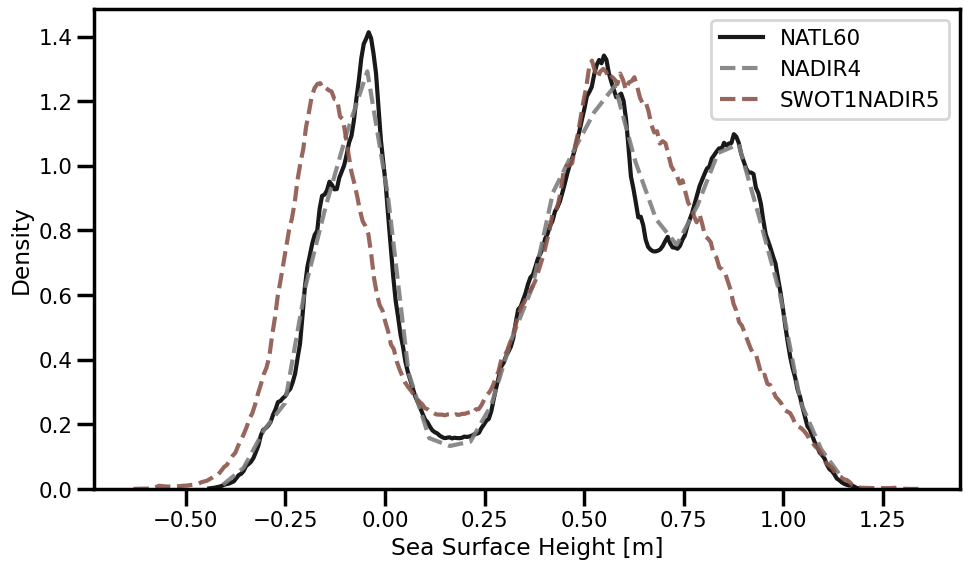

In [12]:

kwargs = {
    "stat": "density",
    "cumulative": False,
    "common_norm": True,
    "fill": False,
    "element": "poly",
    "linewidth": 3,
    "alpha": 0.9
}
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(
    data=ds_natl60.ssh.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs
)
sns.histplot(
    data=ds_nadir4.ssh.values.flatten(),
    ax=ax,
    label="NADIR4",
    color="tab:gray",
    linestyle="--",
    **kwargs
)
sns.histplot(
    data=ds_swot1nadir5.ssh.values.flatten(),
    ax=ax,
    label="SWOT1NADIR5",
    color="tab:brown",
    linestyle="--",
    **kwargs
)


ax.set_xlabel("Sea Surface Height [m]")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend()
fig.savefig(f"./figures/dc20a/densities/natl60_obs_density.png")
plt.show()


### Cumulative Density

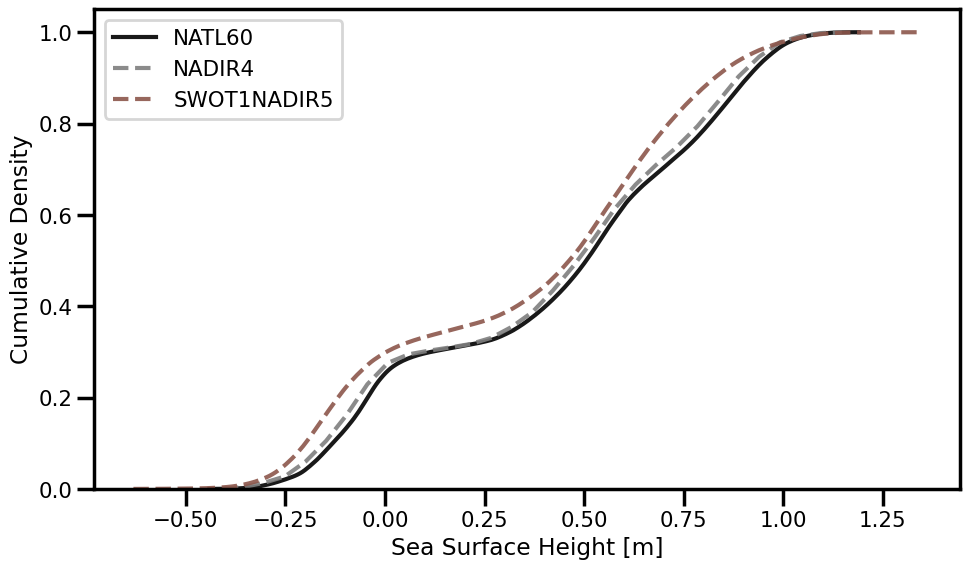

In [13]:

kwargs["cumulative"] = True

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(
    data=ds_natl60.ssh.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs
)
sns.histplot(
    data=ds_nadir4.ssh.values.flatten(),
    ax=ax,
    label="NADIR4",
    color="tab:gray",
    linestyle="--",
    **kwargs
)
sns.histplot(
    data=ds_swot1nadir5.ssh.values.flatten(),
    ax=ax,
    label="SWOT1NADIR5",
    color="tab:brown",
    linestyle="--",
    **kwargs
)

ax.set_xlabel("Sea Surface Height [m]")
# ax.set_xlabel(r"Log Kinetic Energy [m$^2$s$^{-2}$]")
# ax.set_xlabel(r"Log Enstropy [s$^{-1}$]")
ax.set_ylabel("Cumulative Density")
plt.tight_layout()
plt.legend()
fig.savefig(f"./figures/dc20a/densities/natl60_obs_cdensity.png")
plt.show()



## Regrdding: AlongTrack -> Uniform Grid

#### AlongTrack -> Uniform Grid

In [12]:
# load config
psd_config = OmegaConf.load('./configs/metrics.yaml')

ds_natl60 = hydra.utils.instantiate(psd_config.fill_nans)(ds_natl60.pint.dequantify())

## Coarsend Versions

In [13]:
ds_natl60 = ds_natl60.coarsen({"lon": 3, "lat": 3}).mean()
ds_natl60

<xarray.Dataset>
Dimensions:  (time: 42, lat: 200, lon: 200)
Coordinates:
  * lon      (lon) float64 -64.97 -64.92 -64.87 -64.82 ... -55.12 -55.07 -55.02
  * lat      (lat) float64 33.03 33.08 33.13 33.18 ... 42.83 42.88 42.93 42.98
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh      (time, lat, lon) float32 0.652 0.6585 0.6642 ... -0.2079 -0.2149
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

### Prediction Datasets 

In [14]:
%%time

# load config

experiment = "swot" # "nadir" # 
if experiment == "nadir":
    # load config
    results_config = OmegaConf.load(f'./configs/results_dc20a_nadir.yaml')

    # instantiate
    ds_duacs = hydra.utils.instantiate(results_config.DUACS_NADIR.data).compute()
    ds_miost = hydra.utils.instantiate(results_config.MIOST_NADIR.data).compute()
    ds_nerf_siren = hydra.utils.instantiate(results_config.NERF_SIREN_NADIR.data).compute()
    ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_NADIR.data).compute()
    ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_NADIR.data).compute()
elif experiment == "swot":
    # load config
    results_config = OmegaConf.load(f'./configs/results_dc20a_swot.yaml')

    # instantiate
    ds_duacs = hydra.utils.instantiate(results_config.DUACS_SWOT.data).compute()
    ds_miost = hydra.utils.instantiate(results_config.MIOST_SWOT.data).compute()
    ds_nerf_siren = hydra.utils.instantiate(results_config.NERF_SIREN_SWOT.data).compute()
    ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_SWOT.data).compute()
    ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_SWOT.data).compute()

CPU times: user 171 ms, sys: 53.9 ms, total: 225 ms
Wall time: 604 ms


In [15]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/ml_ready/

nadir1.nc  nadir4.nc  nadir5.nc  swot1nadir5.nc  swot.nc


## Regrdding

#### Uniform Grid --> Uniform Grid

In [16]:
%%time

ds_duacs = grid_to_regular_grid(
    src_grid_ds=ds_duacs.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_miost = grid_to_regular_grid(
    src_grid_ds=ds_miost.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_siren = grid_to_regular_grid(
    src_grid_ds=ds_nerf_siren.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_ffn = grid_to_regular_grid(
    src_grid_ds=ds_nerf_ffn.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_mlp = grid_to_regular_grid(
    src_grid_ds=ds_nerf_mlp.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)

CPU times: user 10.7 s, sys: 148 ms, total: 10.9 s
Wall time: 10.9 s


### Preprocess Chain

In [17]:
%%time

# load config
psd_config = OmegaConf.load('./configs/metrics.yaml')

ds_duacs = hydra.utils.instantiate(psd_config.fill_nans)(ds_duacs.pint.dequantify())
ds_miost = hydra.utils.instantiate(psd_config.fill_nans)(ds_miost.pint.dequantify())
ds_nerf_siren = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_siren.pint.dequantify())
ds_nerf_ffn = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_ffn.pint.dequantify())
ds_nerf_mlp = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_mlp.pint.dequantify())


CPU times: user 1 s, sys: 722 µs, total: 1 s
Wall time: 1.01 s


## Geophysical Variables

In [18]:
def calculate_physical_quantities(da):
    da["ssh"] = da.ssh * units.meters
    da = geocalc.streamfunction(da, "ssh")
    da = geocalc.geostrophic_velocities(da, variable="psi")
    da = geocalc.kinetic_energy(da, variables=["u", "v"])
    da = geocalc.divergence(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "div")
    da = geocalc.relative_vorticity(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "vort_r")
    da = geocalc.strain_magnitude(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, variable="strain")
    return da

In [19]:
%%time

ds_natl60 = calculate_physical_quantities(correct_labels(ds_natl60).pint.dequantify())
ds_duacs = calculate_physical_quantities(correct_labels(ds_duacs).pint.dequantify())
ds_miost = calculate_physical_quantities(correct_labels(ds_miost).pint.dequantify())
ds_nerf_siren = calculate_physical_quantities(correct_labels(ds_nerf_siren).pint.dequantify())
ds_nerf_ffn = calculate_physical_quantities(correct_labels(ds_nerf_ffn).pint.dequantify())
ds_nerf_mlp = calculate_physical_quantities(correct_labels(ds_nerf_mlp).pint.dequantify())

CPU times: user 3.07 s, sys: 522 ms, total: 3.59 s
Wall time: 3.61 s


### Sea Surface Height

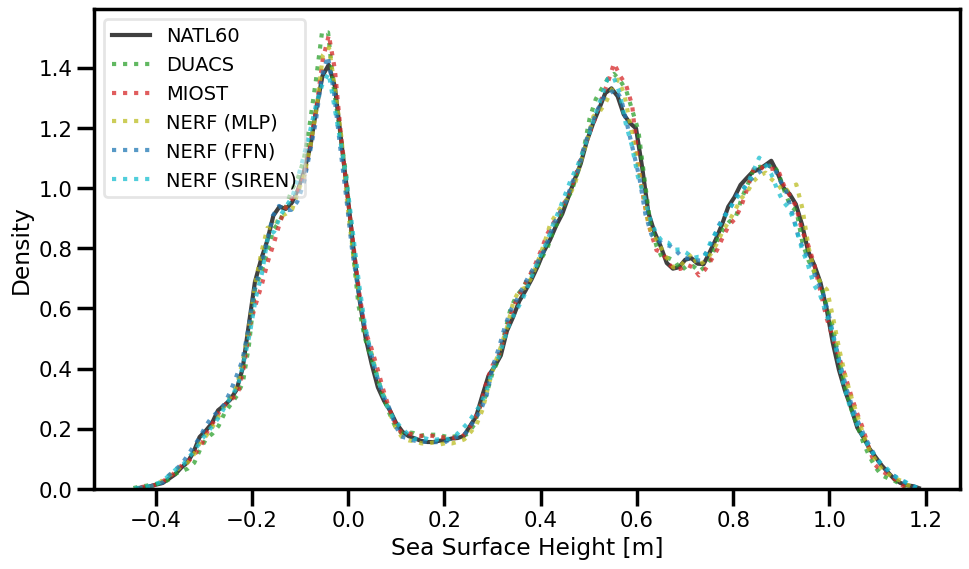

In [20]:

kwargs = {
    "stat": "density",
    "cumulative": False,
    "common_norm": True,
    "fill": False,
    "element": "poly",
    "linewidth": 3,
    "alpha": 0.75
}

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(
    data=ds_natl60.ssh.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs
)
sns.histplot(
    data=ds_duacs.ssh.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle=":",
    **kwargs
)
sns.histplot(
    data=ds_miost.ssh.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.ssh.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.ssh.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.ssh.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle=":",
    **kwargs
)


ax.set_xlabel("Sea Surface Height [m]")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_density_ssh_{experiment}.png")
plt.show()


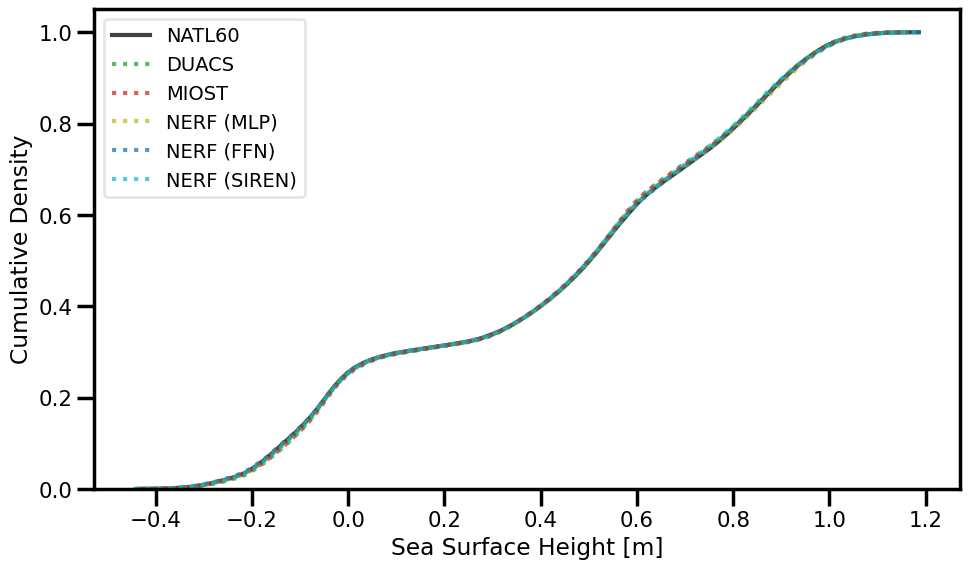

In [21]:
kwargs["cumulative"] = True

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(
    data=ds_natl60.ssh.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs
)
sns.histplot(
    data=ds_duacs.ssh.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle=":",
    **kwargs
)
sns.histplot(
    data=ds_miost.ssh.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.ssh.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.ssh.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.ssh.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle=":",
    **kwargs
)


ax.set_xlabel("Sea Surface Height [m]")
ax.set_ylabel("Cumulative Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_cdensity_ssh_{experiment}.png")
plt.show()

### Kinetic Energy

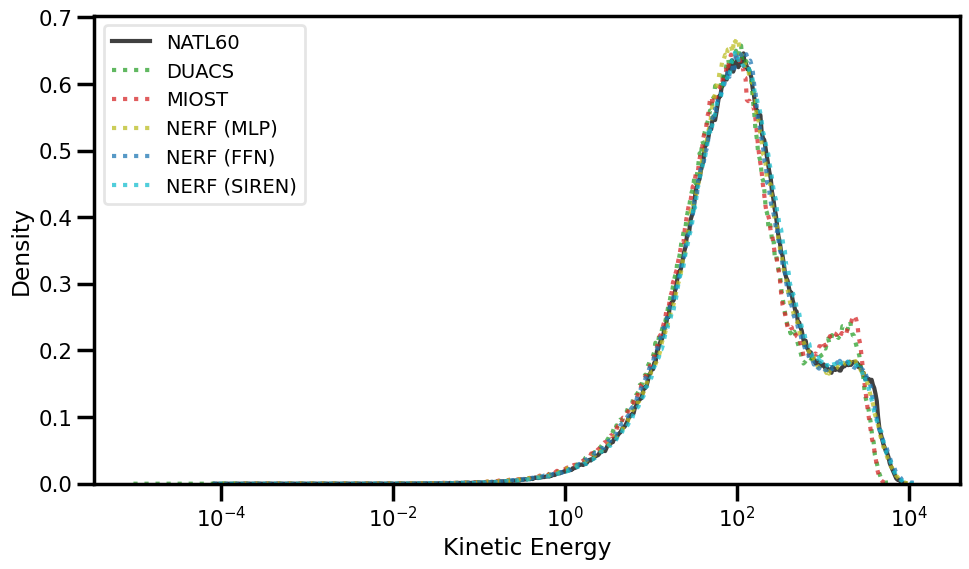

In [22]:

kwargs = {
    "stat": "density",
    "cumulative": False,
    "common_norm": True,
    "fill": False,
    "element": "poly",
    "linewidth": 3,
    "alpha": 0.75,
    "log_scale": True
}

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(
    data=ds_natl60.ke.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs
)
sns.histplot(
    data=ds_duacs.ke.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle=":",
    **kwargs
)
sns.histplot(
    data=ds_miost.ke.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.ke.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.ke.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.ke.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle=":",
    **kwargs
)


ax.set_xlabel("Kinetic Energy")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_density_ke_{experiment}.png")
plt.show()


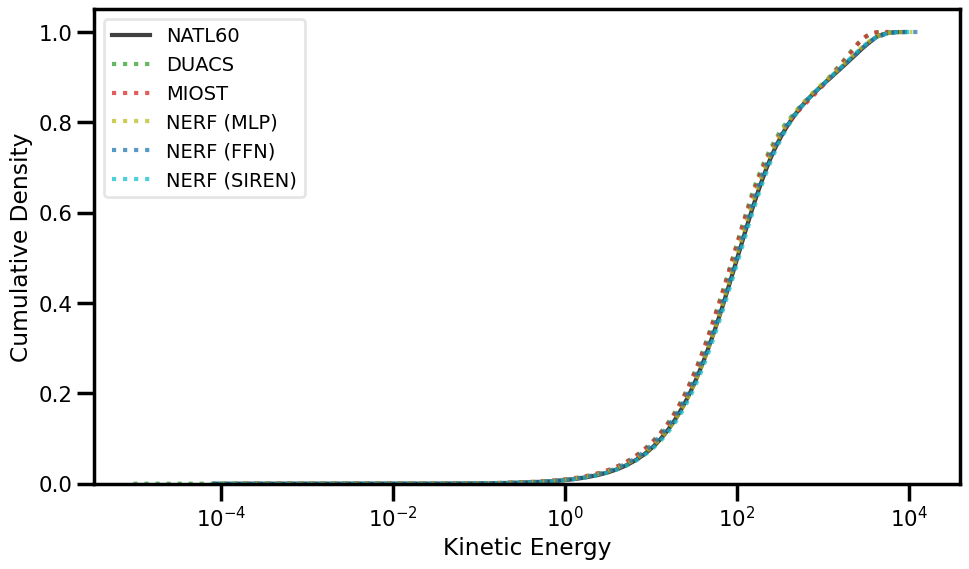

In [23]:
kwargs["cumulative"] = True

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(
    data=ds_natl60.ke.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs
)
sns.histplot(
    data=ds_duacs.ke.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle=":",
    **kwargs
)
sns.histplot(
    data=ds_miost.ke.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.ke.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.ke.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.ke.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle=":",
    **kwargs
)


ax.set_xlabel("Kinetic Energy")
ax.set_ylabel("Cumulative Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_density_cke_{experiment}.png")
plt.show()

### Potential Vorticity

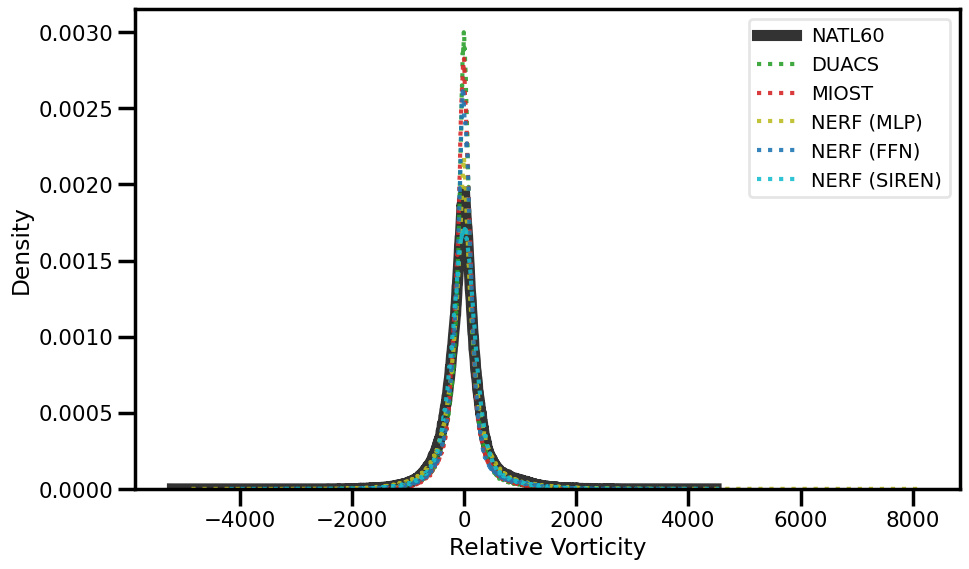

In [24]:

kwargs = {
    "stat": "density",
    "cumulative": False,
    "common_norm": True,
    "fill": False,
    "element": "poly",
    "linewidth": 8,
    "alpha": 0.8,
    "log_scale": False
}

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(
    data=ds_natl60.vort_r.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs
)


kwargs["alpha"] = 0.9
kwargs["linewidth"] = 3
sns.histplot(
    data=ds_duacs.vort_r.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle=":",
    **kwargs
)
sns.histplot(
    data=ds_miost.vort_r.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.vort_r.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.vort_r.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.vort_r.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle=":",
    **kwargs
)


ax.set_xlabel("Relative Vorticity")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_density_vort_r_{experiment}.png")
plt.show()


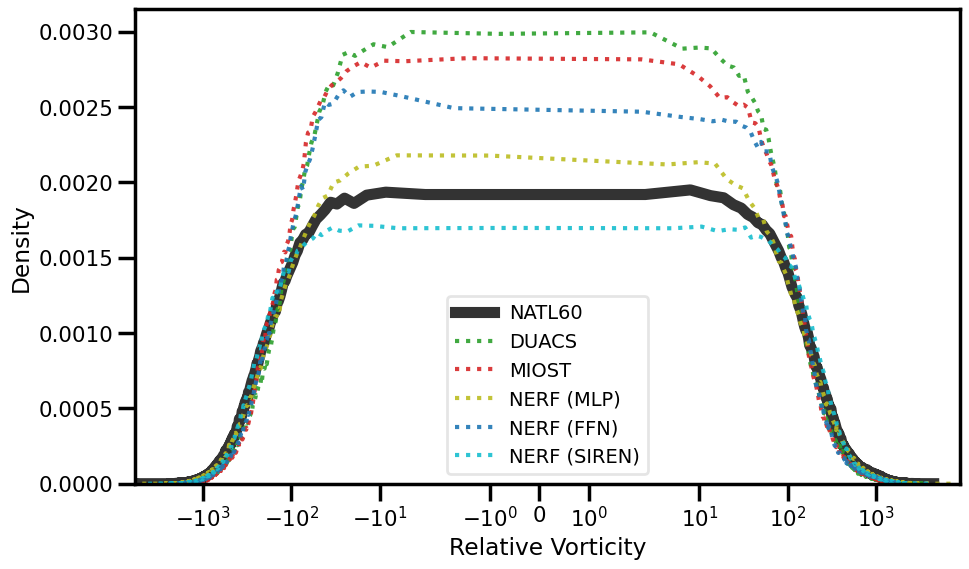

In [25]:

kwargs = {
    "stat": "density",
    "cumulative": False,
    "common_norm": True,
    "fill": False,
    "element": "poly",
    "linewidth": 8,
    "alpha": 0.8,
    "log_scale": False
}

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(
    data=ds_natl60.vort_r.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs
)


kwargs["alpha"] = 0.9
kwargs["linewidth"] = 3
sns.histplot(
    data=ds_duacs.vort_r.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle=":",
    **kwargs
)
sns.histplot(
    data=ds_miost.vort_r.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.vort_r.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.vort_r.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.vort_r.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle=":",
    **kwargs
)

ax.set(xscale="symlog")

ax.set_xlabel("Relative Vorticity")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_density_vort_r_symlog_{experiment}.png")
plt.show()


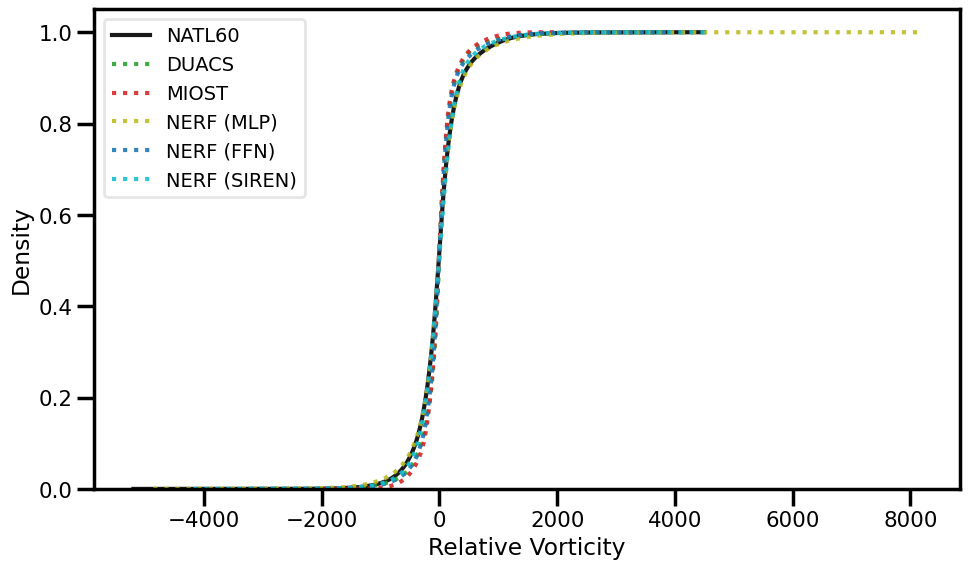

In [26]:
kwargs["cumulative"] = True

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(
    data=ds_natl60.vort_r.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs
)
sns.histplot(
    data=ds_duacs.vort_r.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle=":",
    **kwargs
)
sns.histplot(
    data=ds_miost.vort_r.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.vort_r.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.vort_r.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.vort_r.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle=":",
    **kwargs
)


ax.set_xlabel("Relative Vorticity")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_cdensity_vort_r_{experiment}.png")
plt.show()

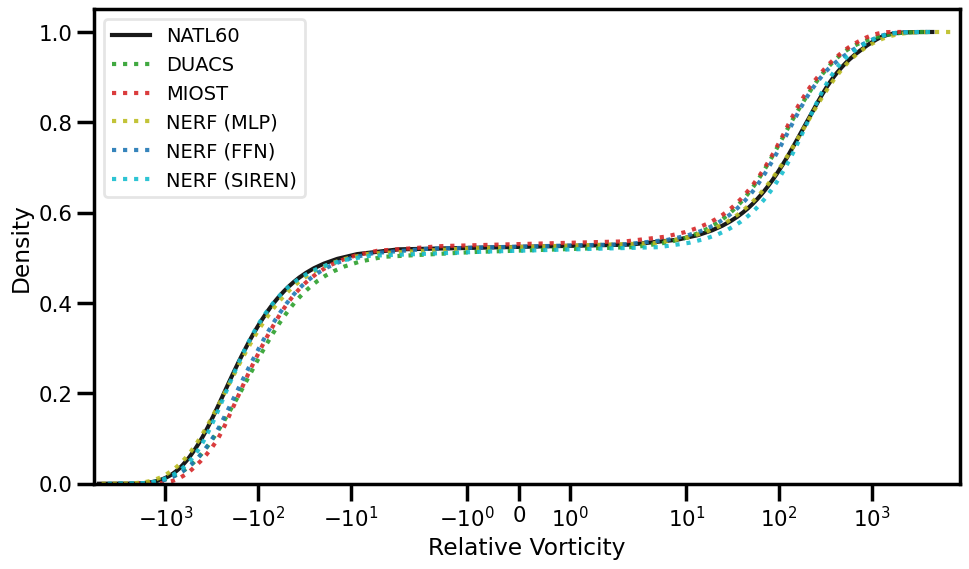

In [27]:
kwargs["cumulative"] = True

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(
    data=ds_natl60.vort_r.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs
)
sns.histplot(
    data=ds_duacs.vort_r.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle=":",
    **kwargs
)
sns.histplot(
    data=ds_miost.vort_r.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.vort_r.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.vort_r.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.vort_r.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle=":",
    **kwargs
)

ax.set(xscale="symlog")

ax.set_xlabel("Relative Vorticity")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_cdensity_vort_r_symlog_{experiment}.png")
plt.show()

### Divergence

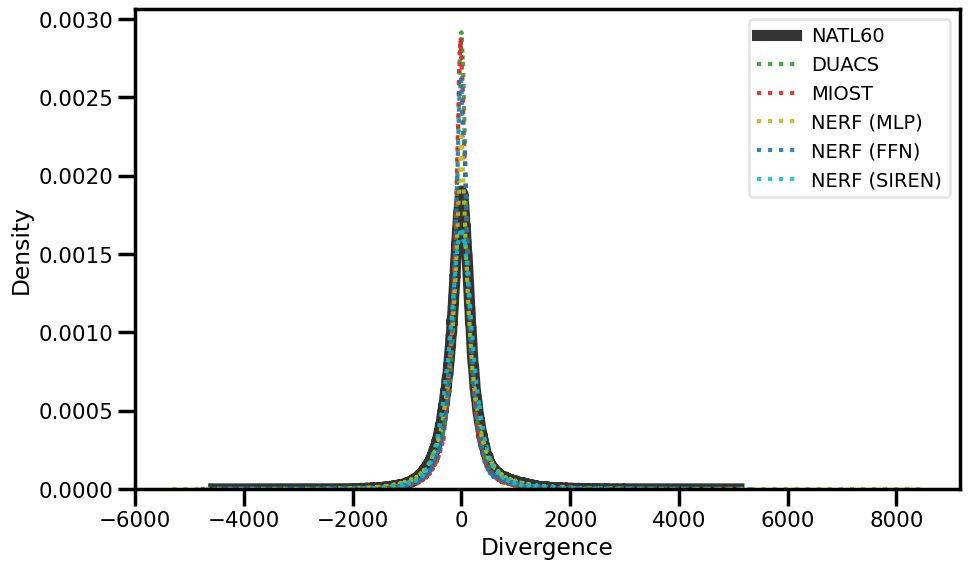

In [28]:

kwargs = {
    "stat": "density",
    "cumulative": False,
    "common_norm": True,
    "fill": False,
    "element": "poly",
    "linewidth": 8,
    "alpha": 0.8,
    "log_scale": False
}

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(
    data=ds_natl60.div.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs
)


kwargs["alpha"] = 0.9
kwargs["linewidth"] = 3
sns.histplot(
    data=ds_duacs.div.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle=":",
    **kwargs
)
sns.histplot(
    data=ds_miost.div.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.div.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.div.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.div.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle=":",
    **kwargs
)


ax.set_xlabel("Divergence")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_density_div_{experiment}.png")
plt.show()

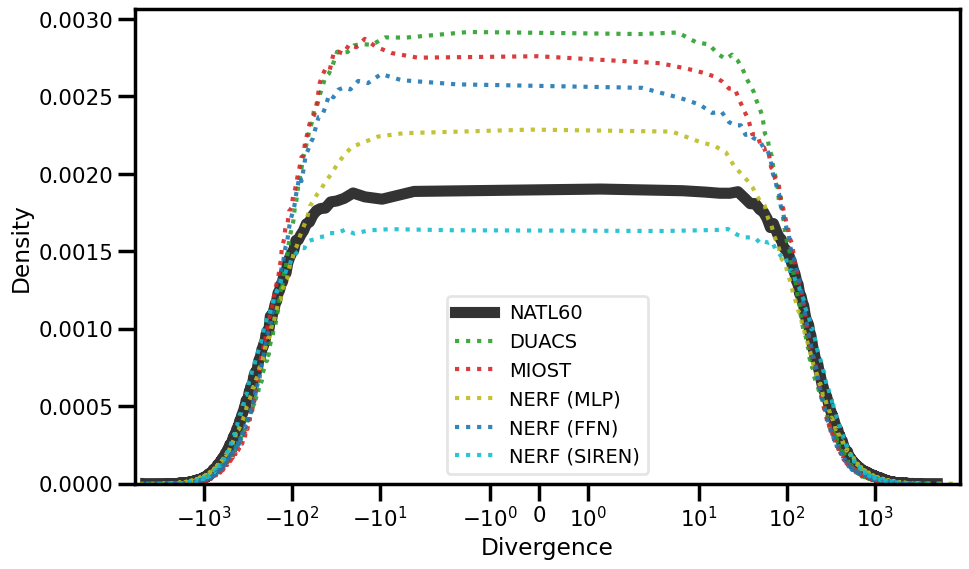

In [29]:

kwargs = {
    "stat": "density",
    "cumulative": False,
    "common_norm": True,
    "fill": False,
    "element": "poly",
    "linewidth": 8,
    "alpha": 0.8,
    "log_scale": False
}

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(
    data=ds_natl60.div.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs
)


kwargs["alpha"] = 0.9
kwargs["linewidth"] = 3
sns.histplot(
    data=ds_duacs.div.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle=":",
    **kwargs
)
sns.histplot(
    data=ds_miost.div.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.div.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.div.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.div.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle=":",
    **kwargs
)
ax.set(xscale="symlog")


ax.set_xlabel("Divergence")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_density_div_symlog_{experiment}.png")
plt.show()


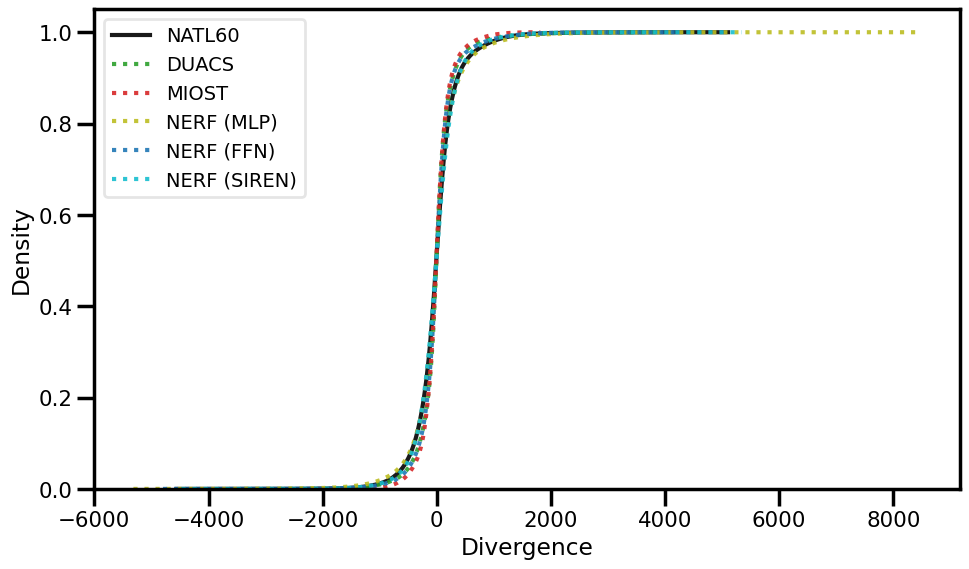

In [30]:
kwargs["cumulative"] = True

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(
    data=ds_natl60.div.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs
)
sns.histplot(
    data=ds_duacs.div.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle=":",
    **kwargs
)
sns.histplot(
    data=ds_miost.div.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.div.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.div.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.div.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle=":",
    **kwargs
)

# ax.set(xscale="symlog")

ax.set_xlabel("Divergence")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_cdensity_div_{experiment}.png")
plt.show()

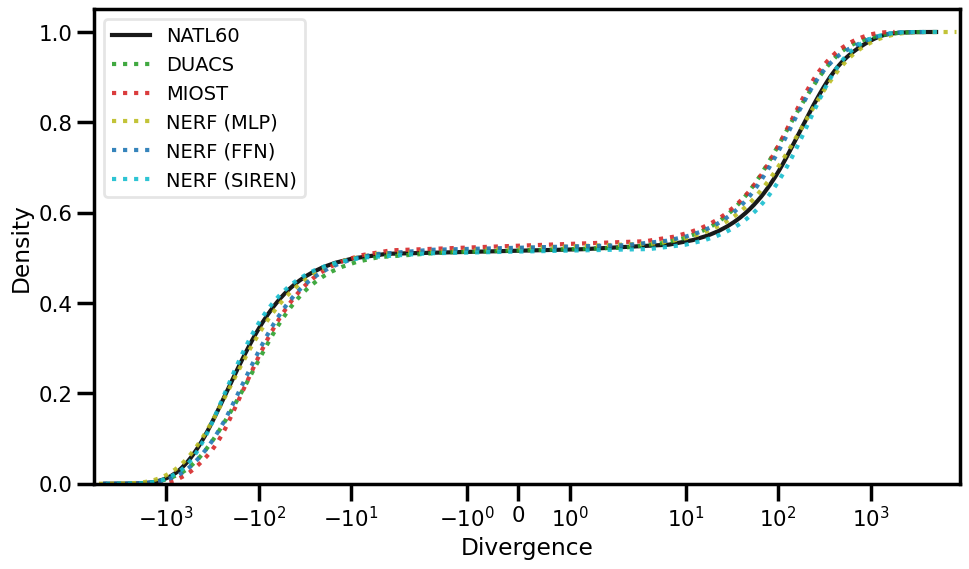

In [31]:
kwargs["cumulative"] = True

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(
    data=ds_natl60.div.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs
)
sns.histplot(
    data=ds_duacs.div.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle=":",
    **kwargs
)
sns.histplot(
    data=ds_miost.div.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.div.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.div.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.div.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle=":",
    **kwargs
)

ax.set(xscale="symlog")

ax.set_xlabel("Divergence")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_cdensity_div_symlog_{experiment}.png")
plt.show()

### Strain

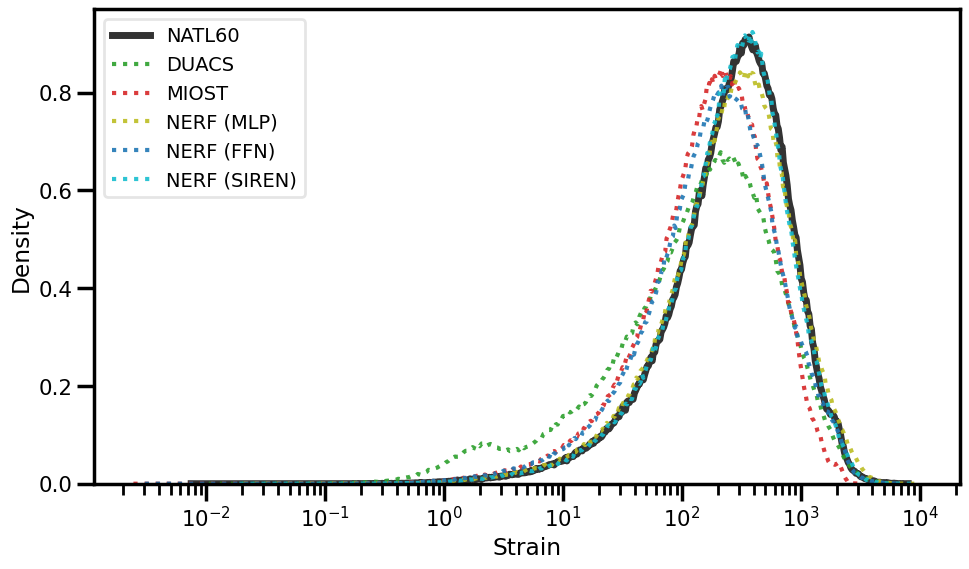

In [32]:

kwargs = {
    "stat": "density",
    "cumulative": False,
    "common_norm": True,
    "fill": False,
    "element": "poly",
    "linewidth": 5,
    "alpha": 0.8,
    "log_scale": True
}

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(
    data=ds_natl60.strain.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs
)


kwargs["alpha"] = 0.9
kwargs["linewidth"] = 3
sns.histplot(
    data=ds_duacs.strain.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle=":",
    **kwargs
)
sns.histplot(
    data=ds_miost.strain.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.strain.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.strain.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.strain.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle=":",
    **kwargs
)


ax.set_xlabel("Strain")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_density_strain_{experiment}.png")
plt.show()

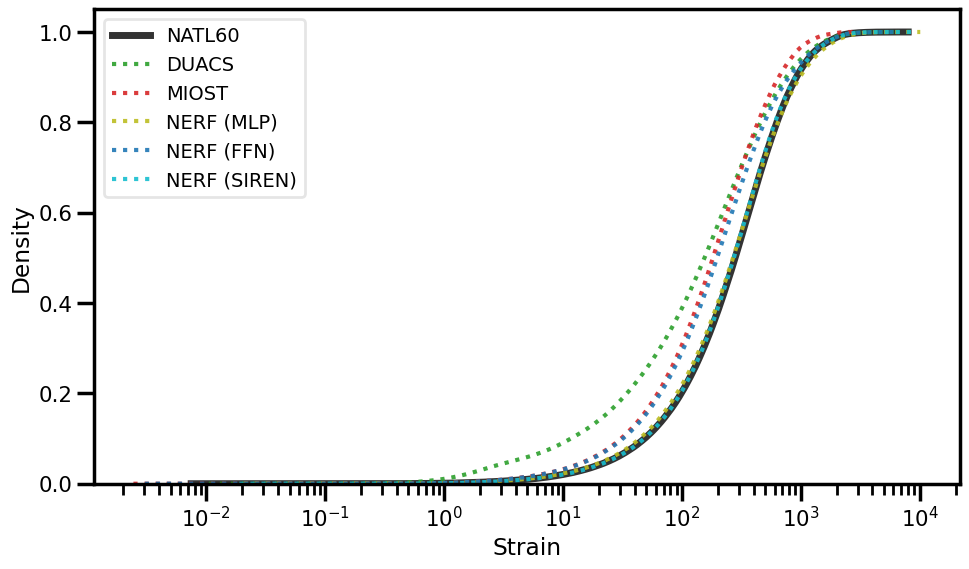

In [33]:

kwargs = {
    "stat": "density",
    "cumulative": True,
    "common_norm": True,
    "fill": False,
    "element": "poly",
    "linewidth": 5,
    "alpha": 0.8,
    "log_scale": True
}

fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(
    data=ds_natl60.strain.values.flatten(),
    ax=ax,
    label="NATL60",
    color="black",
    zorder=1,
    **kwargs
)


kwargs["alpha"] = 0.9
kwargs["linewidth"] = 3
sns.histplot(
    data=ds_duacs.strain.values.flatten(),
    ax=ax,
    label="DUACS",
    color="tab:green",
    linestyle=":",
    **kwargs
)
sns.histplot(
    data=ds_miost.strain.values.flatten(),
    ax=ax,
    label="MIOST",
    color="tab:red",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_mlp.strain.values.flatten(),
    ax=ax,
    label="NERF (MLP)",
    color="tab:olive",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_ffn.strain.values.flatten(),
    ax=ax,
    label="NERF (FFN)",
    color="tab:blue",
    linestyle=":",
    **kwargs
)

sns.histplot(
    data=ds_nerf_siren.strain.values.flatten(),
    ax=ax,
    label="NERF (SIREN)",
    color="tab:cyan",
    linestyle=":",
    **kwargs
)


ax.set_xlabel("Strain")
ax.set_ylabel("Density")
plt.tight_layout()
plt.legend(fontsize=14, framealpha=0.5)
fig.savefig(f"./figures/dc20a/densities/dc20a_cdensity_strain_{experiment}.png")
plt.show()

In [34]:
var_names = [
    "Sea Surface Height", "Kinetic Energy", "Divergence", "Relative Vorticity", "Strain Magnitude"
]

def pixel_stack(ds):
    
    pixel_stack = np.vstack([
        ds.ssh.mean(dim="time").values.ravel(),
        np.log(ds.ke.mean(dim="time").values.ravel()),
        ds.div.mean(dim="time").values.ravel(),
        ds.vort_r.mean(dim="time").values.ravel(),
        np.sqrt(ds.strain.mean(dim="time").values.ravel())
    ]).T
    
    return pd.DataFrame(data=pixel_stack, columns=var_names)

### NATL60

In [35]:
df = pixel_stack(ds_natl60)

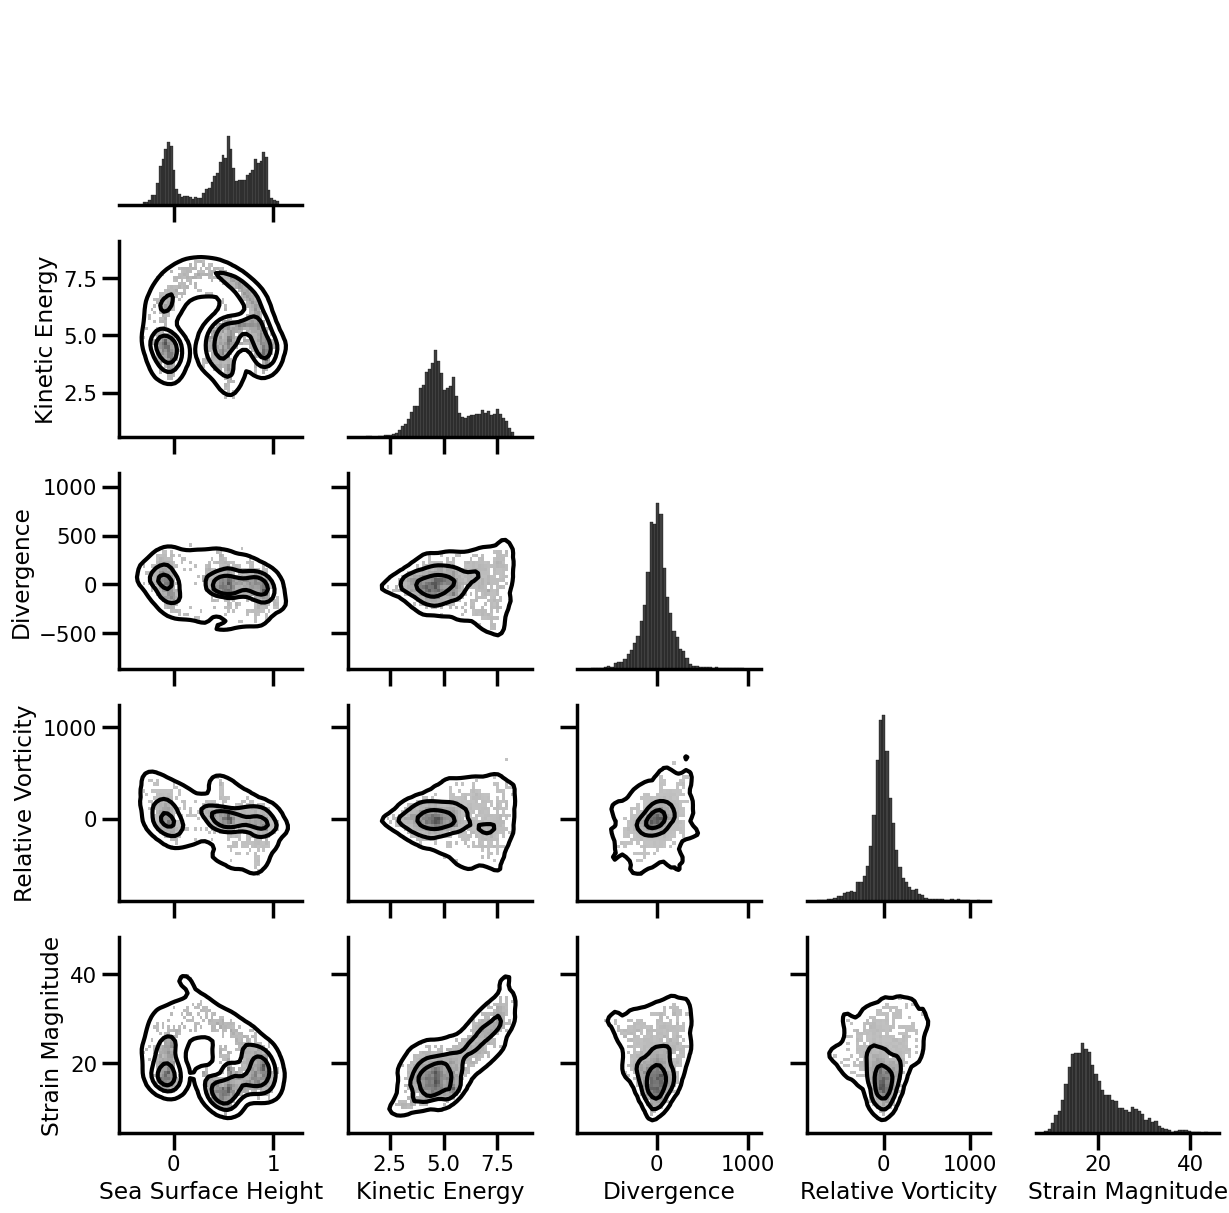

In [36]:
# g = sns.PairGrid(df.sample(5_000))
g = sns.PairGrid(df.sample(10_000), corner=True)
# g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, levels=4, gridsize=50, color="black")
g.map_lower(sns.histplot, bins=50, pthresh=.1, color="black")
# g.map_diag(sns.kdeplot, lw=3, legend=False, levels=4, gridsize=50)
g.map_diag(sns.histplot, bins=50, pthresh=.1, color="black")

g.savefig(f"./figures/dc20a/densities/dc20a_natl60_jointdensity_{experiment}.png")

### DUACS

In [37]:
df = pixel_stack(ds_duacs)

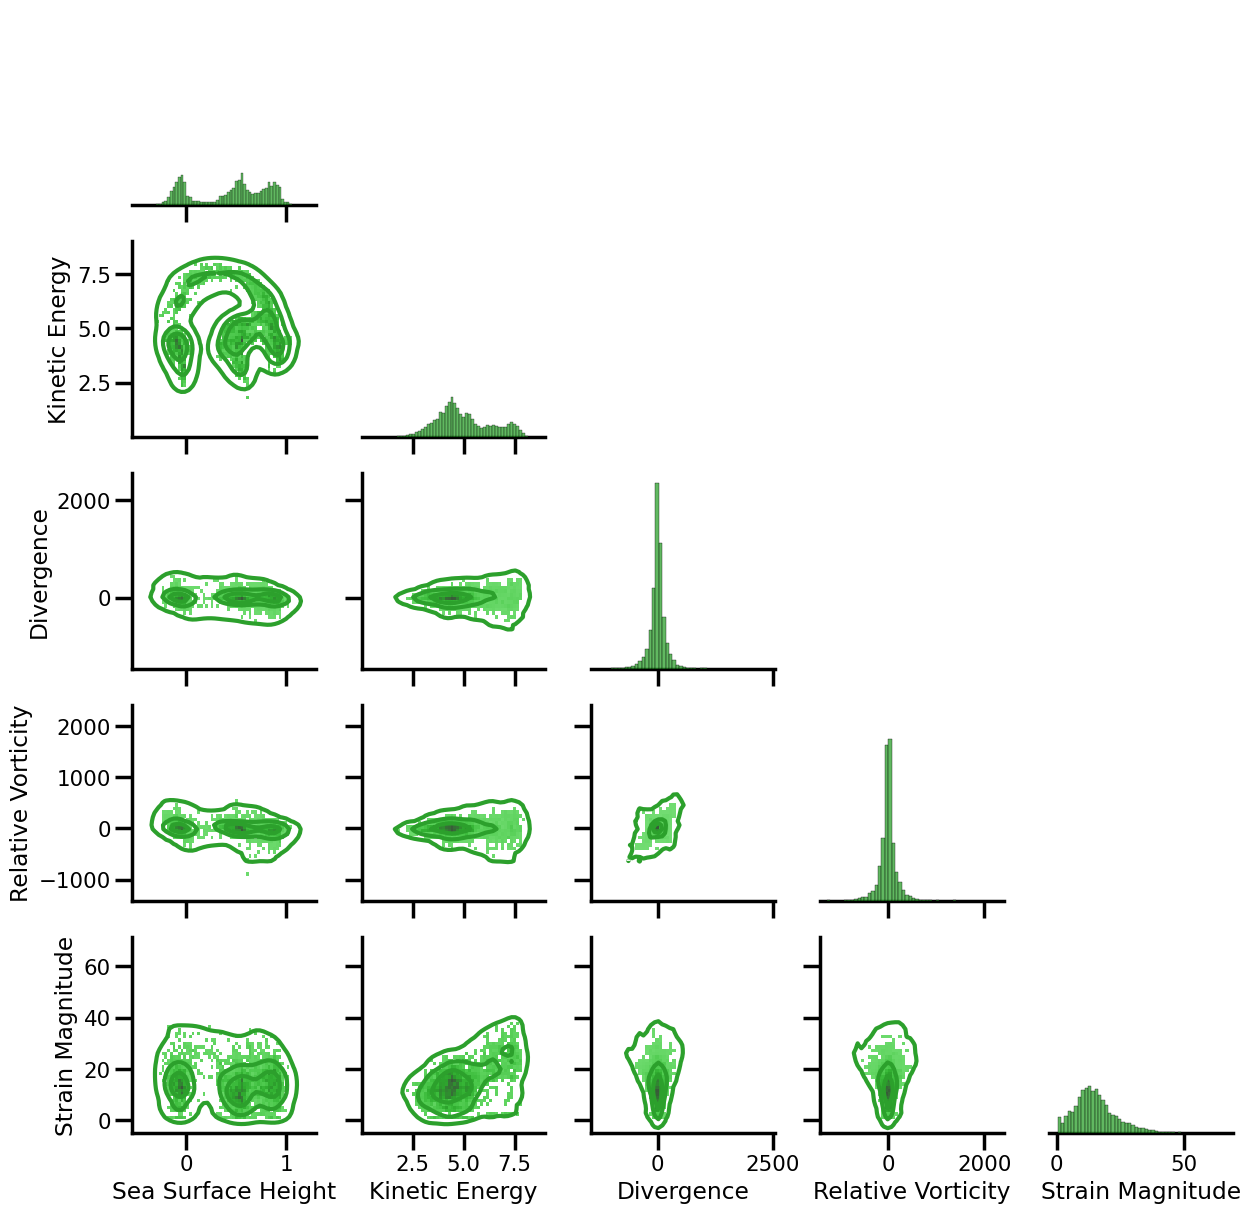

In [38]:
# g = sns.PairGrid(df.sample(5_000))
g = sns.PairGrid(df.sample(10_000), corner=True)
# g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, levels=4, gridsize=50, color="tab:green")
g.map_lower(sns.histplot, bins=50, pthresh=.1, color="tab:green")
# g.map_diag(sns.kdeplot, lw=3, legend=False, levels=4, gridsize=50)
g.map_diag(sns.histplot, bins=50, pthresh=.1, color="tab:green")

g.savefig(f"./figures/dc20a/densities/dc20a_duacs_jointdensity_{experiment}.png")

### MIOST

In [39]:
df = pixel_stack(ds_miost)

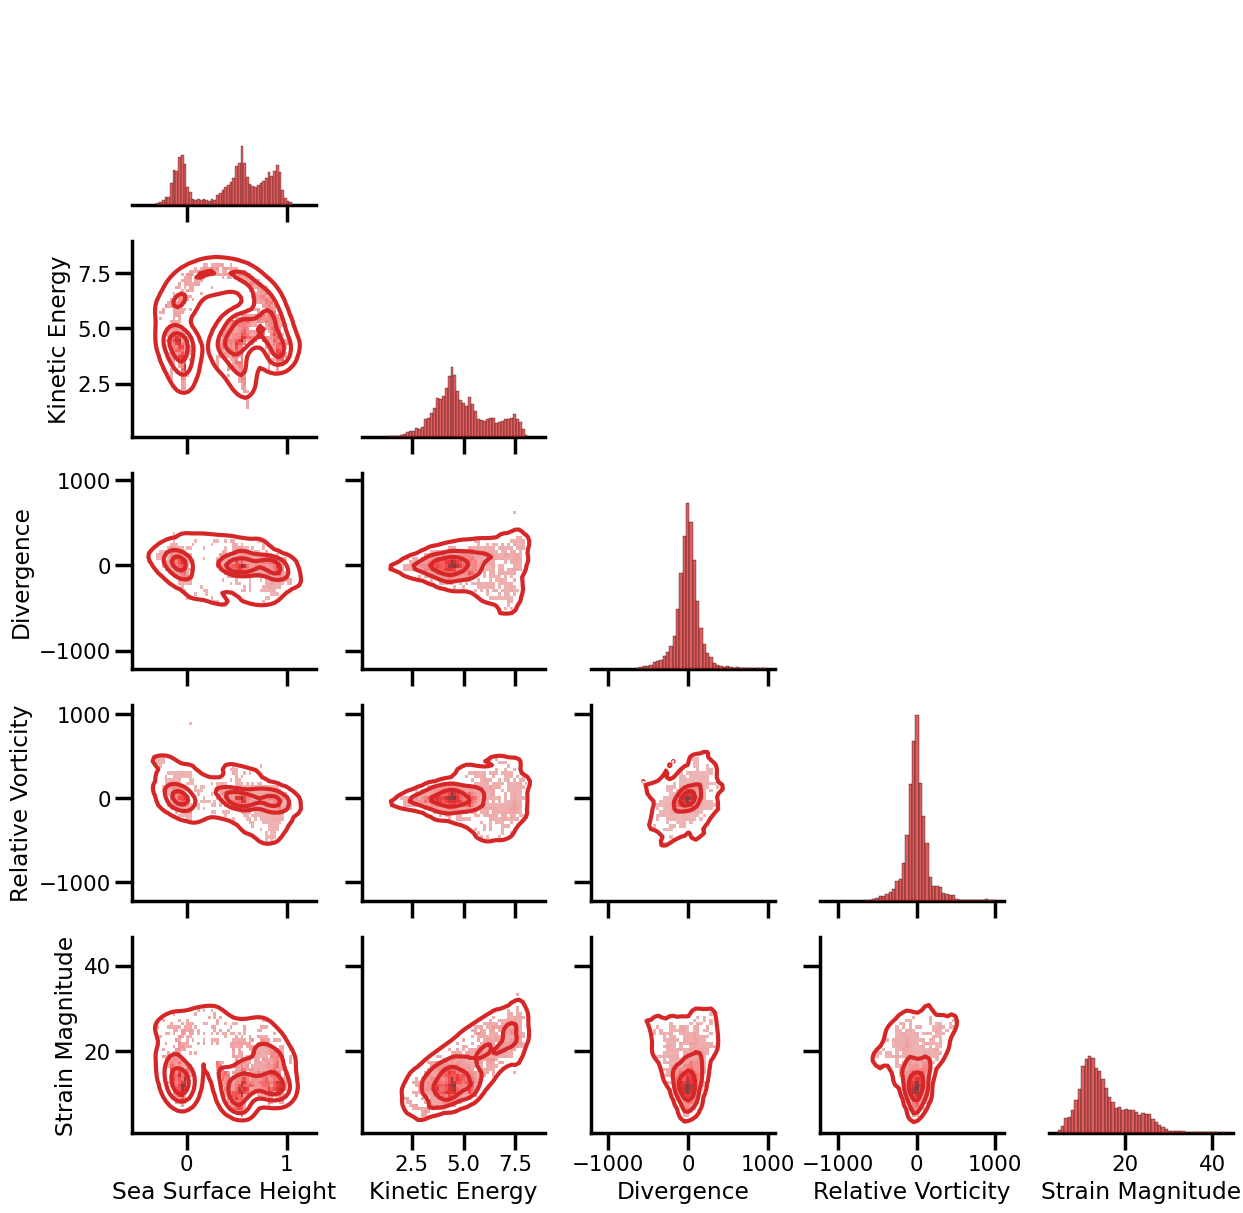

In [40]:
# g = sns.PairGrid(df.sample(5_000))
g = sns.PairGrid(df.sample(10_000), corner=True)
# g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, levels=4, gridsize=50, color="tab:red")
g.map_lower(sns.histplot, bins=50, pthresh=.1, color="tab:red")
# g.map_diag(sns.kdeplot, lw=3, legend=False, levels=4, gridsize=50)
g.map_diag(sns.histplot, bins=50, pthresh=.1, color="tab:red")

g.savefig(f"./figures/dc20a/densities/dc20a_miost_jointdensity_{experiment}.png")

### NERF (MLP)

In [41]:
df = pixel_stack(ds_nerf_mlp)

In [ ]:
# g = sns.PairGrid(df.sample(5_000))
g = sns.PairGrid(df.sample(10_000), corner=True)
# g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, levels=4, gridsize=50, color="tab:cyan")
g.map_lower(sns.histplot, bins=50, pthresh=.1, color="tab:cyan")
# g.map_diag(sns.kdeplot, lw=3, legend=False, levels=4, gridsize=50)
g.map_diag(sns.histplot, bins=50, pthresh=.1, color="tab:cyan")

g.savefig(f"./figures/dc20a/densities/dc20a_nerf_mlp_jointdensity_{experiment}.png")

### NERF (FFN)

In [ ]:
df = pixel_stack(ds_nerf_ffn)

In [ ]:
# g = sns.PairGrid(df.sample(5_000))
g = sns.PairGrid(df.sample(10_000), corner=True)
# g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, levels=4, gridsize=50, color="tab:blue")
g.map_lower(sns.histplot, bins=50, pthresh=.1, color="tab:blue")
# g.map_diag(sns.kdeplot, lw=3, legend=False, levels=4, gridsize=50)
g.map_diag(sns.histplot, bins=50, pthresh=.1, color="tab:blue")

g.savefig(f"./figures/dc20a/densities/dc20a_nerf_ffn_jointdensity_{experiment}.png")

### NERF (SIREN)

In [ ]:
df = pixel_stack(ds_nerf_siren)

In [ ]:
# g = sns.PairGrid(df.sample(5_000))
g = sns.PairGrid(df.sample(10_000), corner=True)
# g.map_upper(sns.scatterplot, size=0.1)
g.map_lower(sns.kdeplot, levels=4, gridsize=50, color="tab:olive")
g.map_lower(sns.histplot, bins=50, pthresh=.1, color="tab:olive")
# g.map_diag(sns.kdeplot, lw=3, legend=False, levels=4, gridsize=50)
g.map_diag(sns.histplot, bins=50, pthresh=.1, color="tab:olive")

g.savefig(f"./figures/dc20a/densities/dc20a_nerf_siren_jointdensity_{experiment}.png")